In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
np.set_printoptions(precision=6, suppress = True)
pd.options.display.float_format = '{:.6f}'.format

## Частина перша: статистика Дарбіна-Уотсона

In [2]:
def DurbinWatson(eps):
    return ((eps[1:] - eps[:-1])**2).sum()/(eps**2).sum()

In [3]:
dw_test = np.loadtxt('./lab3_data/example_for_DW.txt')

In [4]:
DurbinWatson(dw_test)

1.2288100804239723

## Частина друга: побудова адекватного рівняння для опису процесу

In [5]:
rts1 = pd.read_csv('./lab3_data/rts1.txt', squeeze=True, header=None, names=['rts1'])
rts1996 = pd.read_csv('./lab3_data/1996rts1.txt', squeeze=True, header=None, names=['1996rts1'])

Описові характеристики та гістрограма

In [6]:
from scipy.stats import jarque_bera

def DescrStats(series):
    return pd.Series({
        'Mean': series.mean(),
        'Median': series.median(),
        'Maximum': series.max(),
        'Minimum': series.min(),
        'Std. Dev.': series.std(),
        'Skewness': series.skew(),
        'Kurtosis': series.kurt(),
        'Jarque-Bera': jarque_bera(series).statistic,
        'Probability': jarque_bera(series).pvalue
    })

Mean          2043.537303
Median        2068.170000
Maximum       2487.920000
Minimum       1058.840000
Std. Dev.      289.921448
Skewness        -1.082895
Kurtosis         1.442272
Jarque-Bera     48.094769
Probability      0.000000
dtype: float64


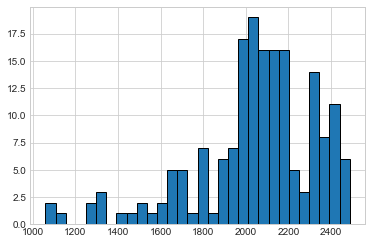

In [7]:
print(DescrStats(rts1))
plt.hist(rts1, bins=30, facecolor='tab:blue', edgecolor='black')
plt.show()

Mean          142.147390
Median        163.150000
Maximum       227.790000
Minimum        66.690000
Std. Dev.      46.972694
Skewness       -0.360544
Kurtosis       -1.473238
Jarque-Bera    27.682686
Probability     0.000001
dtype: float64


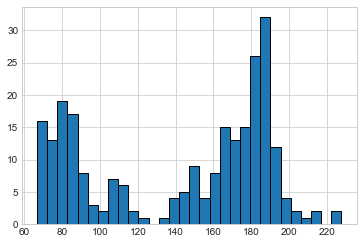

In [8]:
print(DescrStats(rts1996))
plt.hist(rts1996, bins=30, facecolor='tab:blue', edgecolor='black')
plt.show()

Реалізація АКФ, ЧАКФ та ковзних середніх (з ЛР №2)

In [9]:
def ACF(data, maxlag=None):
    N = maxlag if maxlag else data.size
    return np.array([((data - data.mean()) * (data.shift(s) - data.mean())).sum()
            / ((data.size - 1) * data.var())
            for s in range(1, data.size+1)][:N])

def PACF(data, maxlag=None):
    N = maxlag if maxlag else data.size
    r = ACF(data)
    phi = np.zeros((N, N))
    phi[0, 0] = r[0]   
    for k in range(1, N):
        sum_top = sum([phi[k-1, j]*r[k-1-j] for j in range (0, k)])
        sum_bottom = sum([phi[k-1, j]*r[j] for j in range (0, k)])
        phi[k, k] = (r[k] - sum_top) / (1 - sum_bottom)
        for j in range(0, k):
            phi[k, j] = phi[k-1, j] - phi[k, k]*phi[k-1, k-1-j]
            phi[j, k] = phi[k, j]      
    return np.diag(phi)

def SMA(data, N):
    sma = data.rolling(N).mean()
    sma.name += f' SMA (N={N})'
    return sma

def EMA(data, N, return_weights=False):
    a = 2 / (N + 1)
    w = [(1 - a)**n for n in range(N, 0, -1)]
    ema = data.rolling(N).apply(lambda window: (w * window).sum() / sum(w))
    ema.name += f' EMA (N={N})'
    return (ema, w) if return_weights else ema

Статистики для моделі

In [10]:
def sum_squared_error(y_true, y_pred):
    return ((y_true - y_pred)**2).sum()

def r_squared(y_true, y_pred):
    return y_pred.var()/y_true.var()

def log_likelihood(y_true, y_pred):
    N = len(y_pred)
    return -N/2*(np.log(2*np.pi) + np.log(sum_squared_error(y_true, y_pred)/N))

def akaike(y_true, y_pred, ARMA):
    n = ARMA[0] + ARMA[1] + 1
    N = y_true.size 
    return -2*log_likelihood(y_true, y_pred)/N + 2*n/N

def schwarz(y_true, y_pred, ARMA):
    n = ARMA[0] + ARMA[1] + 1
    N = y_true.size 
    return -2*log_likelihood(y_true, y_pred)/N + n*np.log(N)/N

def ModelEstimation(y_true, y_pred, ARMA):
    N = len(y_pred)
    n = ARMA[0] + ARMA[1] + 1
    return pd.Series({
        'R-squared': r_squared(y_true, y_pred),
        'Adjusted R-squared': 1 - (1-r_squared(y_true, y_pred))*((N-1)/(N-n-1)),
        'S.E. of regression': np.sqrt(sum_squared_error(y_true, y_pred)/N),
        'Sum squared resid': sum_squared_error(y_true, y_pred),
        'Log likelihood': log_likelihood(y_true, y_pred),
        'Durbin-Watson stat': DurbinWatson(y_pred - y_true),
        'Mean dependent var': y_pred.mean(),
        'S.D. dependent var': y_pred.std(),
        'Akaike info criterion': akaike(y_true, y_pred, ARMA),
        'Schwarz criterion': schwarz(y_true, y_pred, ARMA)
    })

Побудова моделі

In [11]:
def ARMA(y, ma_window, ma_type, method='resid', pacf_tolerance=None):
    """
    Estimate (p, q) for ARMA(p, q) and fit to y
    
    y               - time series
    ma_window       - moving average window
    ma_type         - sma or ema for simple or exponential moving average
    method          - way of estimating q
    pacf_tolerance  - threshold for choosing q by PACF, 
                      if None, using 1.96/sqrt(len(y))
    Methods:
        resid       - q estimated using PACF of AR(p) residuals
        direct_1    - q estimated using PACF of y moving average, coefs are precomputed
        direct_2    - q estimated using PACF of y moving average, coefs are fitted
    """
    N = ma_window
    if pacf_tolerance is None:
        pacf_tolerance = 1.96 / np.sqrt(len(y))
    try:
        p = np.where(abs(PACF(y, maxlag=12)) >= pacf_tolerance)[0].max()+1
    except ValueError:
        p = 0

    if method == 'resid':
        Y = np.ones((len(y)-p, p+1))
        for k in range(1, p+1):
            Y[:, k] = y[p-k:-k]
        a_coef = np.linalg.pinv(Y.T @ Y) @ Y.T @ y[p:]
        residuals = y[p:] - Y @ a_coef
        try:
            q = np.where(abs(PACF(residuals.dropna(), maxlag=12)) >= pacf_tolerance)[0].max()+1
        except ValueError:
            q = 0
        if ma_type == 'sma':
            ma = SMA(residuals, N)
        elif ma_type == 'ema':
            ma = EMA(residuals, N)
        else: raise ValueError('unknown Moving Average type') 
        ma = ma.dropna()
        actual = y[ma.index[0]:]
        X = np.ones((len(actual)-max(p, q), p+q+1))
        for k in range(1, p+1):
            X[:, k] = actual[max(p, q)-k:-k]
        for k in range(1, q+1):
            X[:, p+k] = ma[max(p, q)-k:-k]
        a_coef = np.linalg.pinv(X.T @ X) @ X.T @ (actual - ma)[max(p, q):]
        fitted = X @ a_coef + ma[max(p, q):]
        fitted.name += ' fitted'
        actual = actual[max(p, q):]

    elif method == 'direct_1' or method == 'direct_2':
        if ma_type == 'sma':
            ma = SMA(y, N).dropna()
        elif ma_type == 'ema':
            ma = EMA(y, N).dropna()
        else: raise ValueError('unknown Moving Average type') 
        try:
            q = np.where(abs(PACF(ma, maxlag=12)) >= pacf_tolerance)[0].max()+1
        except ValueError:
            q = 0
        actual = y[ma.index[0]:]
        if method == 'direct_1':
            alpha = 2/(q+1)
            b_coef = np.array([(1-alpha)**j for j in range(1, q+1)])
            b_coef = b_coef/b_coef.sum() if q>1 else np.ones(1)
            ma_matrix = np.ones((len(ma)-q, q))
            for k in range(q):
                ma_matrix[:, q-k-1] = ma.shift(q-k)[q:]
            y1 = actual[q:] - ma[q:] - ma_matrix @ b_coef
            Y = np.ones((len(y1), p+1))
            start_ind = y1.index[0]
            for k in range(1, p+1):
                Y[:, k] = y[start_ind-k:-k]
            a_coef = np.linalg.pinv(Y.T @ Y) @ Y.T @ y1
            actual = (y1 + ma_matrix @ b_coef + ma).dropna()
            fitted = Y @ a_coef + ma_matrix @ b_coef + ma[q:]
            fitted.name += ' fitted'
            a_coef = np.concatenate((a_coef, b_coef))
        if method == 'direct_2':
            start_ind = ma.index[0] + q
            X = np.ones((len(ma)-q, p+q+1))
            for k in range(1, q+1):
                X[:, p+k] = ma.shift(k)[q:]
            for k in range(1, p+1):
                X[:, k] = y[start_ind-k:-k]
            a_coef = np.linalg.pinv(X.T @ X) @ X.T @ (actual - ma)[q:]
            fitted = X @ a_coef + ma[q:]
            fitted.name += ' fitted'
            actual = actual[q:]

    return {'actual': actual,
            'fitted': fitted,
            'coefficients': a_coef,
            'residuals': actual - fitted,
            'moving_average': ma,
            'model_order': (p, q)}


R-squared                  0.990581
Adjusted R-squared         0.990341
S.E. of regression         3.023243
Sum squared resid       2221.019720
Log likelihood          -492.140285
Durbin-Watson stat         2.006812
Mean dependent var       143.444815
S.D. dependent var        46.490474
Akaike info criterion      4.099920
Schwarz criterion          4.186168
dtype: float64


y(k) = 0.8197 + 0.8416*y(k-1) - 0.4333*y(k-2) + 0.1878*y(k-3) + mv(k) - 0.6791*mv(k-1) + 0.0790*mv(k-2) 


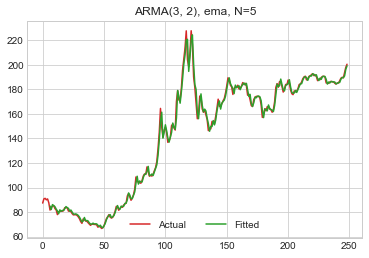

In [12]:
model_params = {
    'y': rts1996,
    'ma_window': 5,
    'ma_type': 'ema',
    'method': 'direct_2'
}
estim = ARMA(**model_params)
plt.plot(model_params['y'], label='Actual', color='tab:red')
plt.plot(estim['fitted'], label='Fitted', color='tab:green')
plt.title(f'ARMA{estim["model_order"]}, {model_params["ma_type"]}, N={model_params["ma_window"]}')
plt.legend(loc='lower center', ncol=2)
print(ModelEstimation(estim['actual'].values, estim['fitted'].values, estim['model_order']))
print('\n')

p, q = estim['model_order']
coef = estim['coefficients']
eq = f'y(k) = {coef[0]:.4f} '
for k in range(1, p+1):
    eq += f'+ {coef[k]:.4f}*y(k-{k}) ' if coef[k]>=0 else f'- {-coef[k]:.4f}*y(k-{k}) '
eq += '+ mv(k) '
for k in range(1, q+1):
    eq += f'+ {coef[p+k]:.4f}*mv(k-{k}) ' if coef[p+k]>=0 else f'- {-coef[p+k]:.4f}*mv(k-{k}) '
print(eq)

## Частина третя: побудова рівняння множинної регресії.

In [13]:
def pearson_correlation(x, y):
    if x.shape != y.shape: raise ValueError("Shapes must be equal")
    return np.sum((x-x.mean()) * (y-y.mean())) / (x.std() * y.std() * (len(x)-1))

In [14]:
import re
import os

df = pd.read_csv('./lab3_data/rts1.txt', header=None, names=['rts1'])

rts = [file for file in os.listdir('./lab3_data') if re.match(r'^RTS', file)]

for index in rts:
    df[index.split('.')[0]] = np.loadtxt('./lab3_data/'+index)
    
df.head()

,rts1,RTScr,RTSeu,RTSfn,RTSin,RTSmm,RTSog,RTStl
0,2296.560000,374.120000,465.290000,786.310000,408.620000,363.970000,288.900000,322.850000
1,2306.870000,376.170000,463.220000,788.790000,409.330000,368.810000,289.560000,322.590000
2,2313.900000,380.340000,463.920000,792.270000,413.300000,369.500000,289.200000,324.090000
3,2339.790000,382.760000,465.090000,796.210000,414.340000,376.520000,293.300000,328.120000
4,2330.870000,386.370000,468.230000,793.430000,417.960000,376.050000,291.390000,328.720000


In [15]:
corr = pd.DataFrame(
    [df.apply(lambda x: pearson_correlation(x, df[col1])) for col1 in df.columns],
    index = df.columns
)

corr

,rts1,RTScr,RTSeu,RTSfn,RTSin,RTSmm,RTSog,RTStl
rts1,1.000000,0.848433,0.638377,0.879438,0.859188,0.928940,0.961389,0.822547
RTScr,0.848433,1.000000,0.929083,0.960564,0.897707,0.851709,0.682340,0.956929
RTSeu,0.638377,0.929083,1.000000,0.878301,0.794041,0.697672,0.412473,0.887168
RTSfn,0.879438,0.960564,0.878301,1.000000,0.828220,0.808881,0.739310,0.925300
RTSin,0.859188,0.897707,0.794041,0.828220,1.000000,0.944448,0.726153,0.886036
RTSmm,0.928940,0.851709,0.697672,0.808881,0.944448,1.000000,0.841226,0.798230
RTSog,0.961389,0.682340,0.412473,0.739310,0.726153,0.841226,1.000000,0.667557
RTStl,0.822547,0.956929,0.887168,0.925300,0.886036,0.798230,0.667557,1.000000


Результати аналогічні вбудованій функції, тому надалі для зручності використовуватимемо саме її

In [16]:
df.corr()

,rts1,RTScr,RTSeu,RTSfn,RTSin,RTSmm,RTSog,RTStl
rts1,1.000000,0.848433,0.638377,0.879438,0.859188,0.928940,0.961389,0.822547
RTScr,0.848433,1.000000,0.929083,0.960564,0.897707,0.851709,0.682340,0.956929
RTSeu,0.638377,0.929083,1.000000,0.878301,0.794041,0.697672,0.412473,0.887168
RTSfn,0.879438,0.960564,0.878301,1.000000,0.828220,0.808881,0.739310,0.925300
RTSin,0.859188,0.897707,0.794041,0.828220,1.000000,0.944448,0.726153,0.886036
RTSmm,0.928940,0.851709,0.697672,0.808881,0.944448,1.000000,0.841226,0.798230
RTSog,0.961389,0.682340,0.412473,0.739310,0.726153,0.841226,1.000000,0.667557
RTStl,0.822547,0.956929,0.887168,0.925300,0.886036,0.798230,0.667557,1.000000


In [17]:
df[['rts1', 'RTStl', 'RTScr', 'RTSfn']].corr()

,rts1,RTStl,RTScr,RTSfn
rts1,1.000000,0.822547,0.848433,0.879438
RTStl,0.822547,1.000000,0.956929,0.925300
RTScr,0.848433,0.956929,1.000000,0.960564
RTSfn,0.879438,0.925300,0.960564,1.000000


Спостерігаємо сильну корреляцію між змінними RTStl, RTScr, RTSfn, з трьох залишимо RTSfn, оскільки вона корелює з цільовою змінною найсильніше

Змінна RTSeu має порівняно невеликий коефіцієнт корреляції з rts1, проте й не має суттєвої корреляції з іншими змінними, тому залишимо її в списку предикторів.

Останньою неоднозначною змінною залишається RTSin, що сильно корелює з RTSmm. Спробуємо її також прибрати

In [18]:
excluded = {'rts1', 'RTStl', 'RTScr', 'RTSin'}
predictors = list(set(df.columns) - excluded)
df[['rts1'] + predictors].corr()

,rts1,RTSeu,RTSfn,RTSog,RTSmm
rts1,1.000000,0.638377,0.879438,0.961389,0.928940
RTSeu,0.638377,1.000000,0.878301,0.412473,0.697672
RTSfn,0.879438,0.878301,1.000000,0.739310,0.808881
RTSog,0.961389,0.412473,0.739310,1.000000,0.841226
RTSmm,0.928940,0.697672,0.808881,0.841226,1.000000


In [19]:
import statsmodels.api as sm

y = df['rts1']
X = df[predictors]

X = sm.add_constant(X)
lr = sm.OLS(y, X).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                   rts1   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.294e+04
Date:                Sat, 13 Mar 2021   Prob (F-statistic):          4.71e-258
Time:                        22:09:57   Log-Likelihood:                -647.02
No. Observations:                 178   AIC:                             1304.
Df Residuals:                     173   BIC:                             1320.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -44.0745      5.351     -8.237      0.0

## Частина четверта: творча, ARMAX

In [20]:
import statsmodels.tsa.tsatools as tsa

def PCF(y, x, maxlag=None):
    N = maxlag+1 if maxlag else 1
    r = [pearson_correlation(x.shift(k)[k:], y[k:]) for k in range(N)]
    phi = np.zeros((N, N))
    phi[0, 0] = r[0]   
    for k in range(1, N):
        sum_top = sum([phi[k-1, j]*r[k-1-j] for j in range (0, k)])
        sum_bottom = sum([phi[k-1, j]*r[j] for j in range (0, k)])
        phi[k, k] = (r[k] - sum_top) / (1 - sum_bottom)
        for j in range(0, k):
            phi[k, j] = phi[k-1, j] - phi[k, k]*phi[k-1, k-1-j]
            phi[j, k] = phi[k, j]      
    return np.diag(phi)

X.iloc[:,1:].apply(lambda x: PCF(y, x, 12))

,RTSeu,RTSfn,RTSog,RTSmm
0,0.638377,0.879438,0.961389,0.928940
1,0.355045,0.381713,0.284708,0.468520
2,0.220042,0.187953,0.013817,0.292865
3,0.139585,0.100980,-0.024324,0.207105
4,0.086991,0.037840,-0.027809,0.172166
5,0.054748,-0.000295,0.006279,0.169422
6,0.037164,-0.006252,-0.071175,0.116981
7,0.027557,-0.002099,-0.065246,0.057525
8,0.024877,-0.005768,-0.037691,0.017534
9,0.038678,0.019894,0.002663,-0.027633
